!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install datetime

In [1]:
import pandas as pd
import matplotlib
import pprint

matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
import seaborn as sns
import os
import re
import datetime
import numpy as np

In [2]:

# ====== GLOBAL VARS ===== #
filedir = '/Users/jiyoojeong/desktop/C/Nephila/renewables/raw/forwards/spg/'




In [3]:

# ====== FUNCTIONS ====== #


def combine_market(market):
    # list all in dir with name == to market

    lis = os.listdir(filedir)
    lis.remove('ERCOT')
    date = datetime.datetime.today()
    yesterday = (date - datetime.timedelta(days=1)).strftime("%m%d%Y")
    d = date.strftime("%m%d%Y")
    if market + '_' + d + '.csv' not in os.listdir(filedir + 'ERCOT'):

        # print(d)
        print('Market: ' + market + '  Day: ' + d)
        big_one = pd.DataFrame()
        count = 0
        for f in lis:
            if re.search(market, f) and not re.search('META', f):
                df = pd.read_csv(filedir + f, engine='python')
                # print(df['Unnamed: 0.1'])

                region = df['Unnamed: 0.1'][2]
                region = region.split(':')[1].strip()
                peak = df['Unnamed: 0.1'][4]
                peak = peak.split(':')[1].strip()
                as_of_date = df['Unnamed: 0.1'][6]  # accounts for weekend dates or days data is not available already
                as_of_date = as_of_date.split(':')[1].strip()
                headers = df.iloc[7, :].values
                headers = np.delete(headers, 0)

                # print(region, peak, as_of_date, headers, type(region), type(headers))

                df = df.drop(df.index[[0, 1, 2, 3, 4, 5, 6, 7]])
                df = df.drop(columns=['Unnamed: 0'])

                # change df to add new categorical parameters
                df.columns = headers
                df['AsOfDate'] = as_of_date
                df['Peak'] = peak
                df['Region'] = region
                # print(df)
                # big_one.columns = headers
                big_one = big_one.append(df)
                # print(big_one)
                count += 1
                if count % 100 == 0:
                    # print(df)
                    print(big_one.tail(10))
        os.chdir(filedir)
        # print(os.listdir(filedir))
        if market not in os.listdir(filedir):
            os.makedirs(market)
        bigfilename = filedir + market + '/' + market + '_' + str(d) + '.csv'
        big_one.to_csv(bigfilename)
        return bigfilename
    return filedir + market + '/' + market + '_' + d + '.csv'


def atc(on, off):
    # print(on[0], off[0])
    # print(type(on[0]), type(off[0]))
    b = (lambda x, y: (16.0 / 24) * x + (8.0 / 24 * 5 / 7 + 24 / 24 * 2 / 7) * y)(on.values, off.values)
    return b



In [4]:

# ====== ERCOT ====== #
ercot_files = os.listdir(filedir + 'ERCOT')
# print(ercot_files)
ercot_file = filedir + 'ERCOT/' + 'ERCOT_07282020.csv'  # combine_market('ERCOT')

ercot = pd.read_csv(ercot_file)
# print(ercot.head())
ercot_cols_float = [u'AEN', u'CPS', u'DC_E', u'DC_N', u'DC_R',
                    u'Houston Zone', u'LCRA', u'North Zone', u'OKLA', u'South Zone',
                    u'West Zone']

for c in ercot_cols_float:
    ercot[c] = ercot[c].astype(float)

ercot['AsOfDate'] = pd.to_datetime(ercot['AsOfDate'])
ercot['Term'] = pd.to_datetime(ercot['Term'])
ercot = ercot.drop(columns=['Unnamed: 0'])
# ercot_early = ercot[ercot['AsOfDate'] <= datetime.datetime.strptime('12/31/2013', '%m/%d/%Y')].dropna()
sus = ercot.loc[ercot['Term'] == datetime.datetime.strptime('2019-08-01', '%Y-%m-%d'), : ]
sus = sus.loc[sus['AsOfDate'] == datetime.datetime.strptime('2019-08-19', '%Y-%m-%d'), :]


# get atc

zones = [u'Houston Zone', u'North Zone', u'South Zone', u'West Zone']

ercot_on = ercot.loc[ercot['Peak'] == 'On Peak', :].drop(columns=['Peak'])
ercot_off = ercot.loc[ercot['Peak'] == 'Off Peak', :].drop(columns=['Peak'])

# account for incompleteness?
ercot_on_off = ercot_on.merge(right=ercot_off, left_on=['AsOfDate', 'Term'],
                              right_on=['AsOfDate', 'Term'], how='left').assign(
    Houston=lambda df: atc(df['Houston Zone_x'], df['Houston Zone_y']),
    West=lambda df: atc(df['West Zone_x'], df['West Zone_y']),
    South=lambda df: atc(df['South Zone_x'], df['South Zone_y']),
    North=lambda df: atc(df['North Zone_x'], df['North Zone_y']))

ercot_atc = ercot_on_off[['AsOfDate', 'Term', 'Houston', 'West', 'South', 'North']]
ercot_atc = ercot_atc.rename(columns={'Houston': 'Houston Zone', 'West': 'West Zone',
                                      'South': 'South Zone', 'North': 'North Zone'})
ercot_atc['Peak'] = 'ATC'
ercot_atc['Region'] = 'ERCOT'
ercot = ercot[ercot_atc.columns]
ercot = ercot.append(ercot_atc).sort_values(by=['AsOfDate', 'Term', 'Peak']).drop_duplicates().dropna()


In [5]:
ercot[ercot['West Zone'] > 100]['Term'].dt.month.value_counts()
# months with forward prices greater than 100
# these are all summer months

8    4120
7     959
6       7
9       2
Name: Term, dtype: int64

In [6]:
sus[ercot_atc.columns]

,AsOfDate,Term,Houston Zone,West Zone,South Zone,North Zone,Peak,Region
16068,2019-08-19,2019-08-01,291.2799,402.8399,399.2099,402.9299,On Peak,ERCOT


In [7]:

''' Now we want to get the value difference from the historical to the predicted.'''
''' 
TODO:
- import the historical prices
- match each term date to each historical date
- find the difference
- use this difference as the new values for delta
'''

ERCOT_RT = pd.read_csv('/Users/jiyoojeong/desktop/C/Nephila/renewables/raw/reals/ERCOT/ERCOT_RT.csv')
ERCOT_RT['date'] = pd.to_datetime(ERCOT_RT['date'])
ERCOT_RT['price'] = ERCOT_RT['price'].astype(float)
print(ERCOT_RT)

ercot_zones = pd.melt(ercot,id_vars=['AsOfDate', 'Term', 'Peak'],
                           value_vars=zones,
                           var_name='Subregion')
#print(ercot_zones)
# ercot_rt_reshaped = ERCOT_RT.pivot(index='date', columns=['Peak', 'Subregion'])
# print(ercot_rt_reshaped)

# ercot = ercot.loc[['Houston Zone', 'North Zone', 'South Zone', 'West Zone']]
# ercot_early = ercot.append(ercot_atc).sort_values(by=['AsOfDate', 'Term', 'Peak'])
# TODO: Some magic and find the differences between prices for each term, peak, and region.
ercot_zones.sort_values('value', ascending=False).head(20)


            date      price      Peak     Subregion
0     2010-12-01  24.566667       ATC  Houston Zone
1     2010-12-02  24.228333       ATC  Houston Zone
2     2010-12-03  25.019583       ATC  Houston Zone
3     2010-12-04  23.792188       ATC  Houston Zone
4     2010-12-05  25.658917       ATC  Houston Zone
...          ...        ...       ...           ...
37637 2020-05-30  19.289896  Off Peak     West Zone
37638 2020-05-31  16.022083  Off Peak     West Zone
37639 2020-06-01  16.313958  Off Peak     West Zone
37640 2020-06-02  16.181458  Off Peak     West Zone
37641 2020-06-03  16.717813  Off Peak     West Zone

[37642 rows x 4 columns]


,AsOfDate,Term,Peak,Subregion,value
833162,2019-08-19,2019-08-01,On Peak,North Zone,402.9299
1688764,2019-08-19,2019-08-01,On Peak,West Zone,402.8399
1260963,2019-08-19,2019-08-01,On Peak,South Zone,399.2099
405361,2019-08-19,2019-08-01,On Peak,Houston Zone,291.2799
833282,2019-08-20,2019-08-01,On Peak,North Zone,290.9699
1688884,2019-08-20,2019-08-01,On Peak,West Zone,290.8999
833402,2019-08-21,2019-08-01,On Peak,North Zone,288.4855
1689004,2019-08-21,2019-08-01,On Peak,West Zone,288.4359
1261083,2019-08-20,2019-08-01,On Peak,South Zone,287.2299
1261203,2019-08-21,2019-08-01,On Peak,South Zone,287.0499


In [8]:

ercot_rt_h = ERCOT_RT.merge(ercot_zones, left_on=['date', 'Peak', 'Subregion'], right_on=['Term', 'Peak', 'Subregion'], how='inner')
#print(ercot_rt_h.head())

ercot_rt_h['prediction delta'] = ercot_rt_h['price'] - ercot_rt_h['value']
ercot_rt_h.sort_values('prediction delta')



,date,price,Peak,Subregion,AsOfDate,Term,value,prediction delta
318432,2019-08-01,62.958125,On Peak,North Zone,2019-08-19,2019-08-01,402.929900,-339.971775
712690,2019-08-01,62.870625,On Peak,West Zone,2019-08-19,2019-08-01,402.839900,-339.969275
516956,2019-08-01,63.007656,On Peak,South Zone,2019-08-19,2019-08-01,399.209900,-336.202244
121585,2019-08-01,62.829062,On Peak,Houston Zone,2019-08-19,2019-08-01,291.279900,-228.450838
712691,2019-08-01,62.870625,On Peak,West Zone,2019-08-20,2019-08-01,290.899900,-228.029275
...,...,...,...,...,...,...,...,...
642756,2019-09-01,132.423806,ATC,West Zone,2017-09-14,2019-09-01,27.250429,105.173377
642716,2019-09-01,132.423806,ATC,West Zone,2017-05-11,2019-09-01,27.177667,105.246139
642699,2019-09-01,132.423806,ATC,West Zone,2017-02-22,2019-09-01,27.146286,105.277520
642718,2019-09-01,132.423806,ATC,West Zone,2017-05-15,2019-09-01,27.129333,105.294472


In [9]:

ercot_delta = ercot_rt_h.copy()
# ercot_delta_early = ercot_early.copy()
# monthly window averages
# ercot_delta = ercot.sort_values(by=['Term', 'AsOfDate']).rolling(30, min_periods=1).mean()

# day differences from predicted term date and the as of date
ercot_delta['Delta'] = ercot_delta['Term'] - ercot_delta['AsOfDate']
# ercot_delta_early['Delta'] = ercot_delta_early['Term'] - ercot_delta_early['AsOfDate']
# print(ercot_delta.head())
# drop index to make uniform
ercot_delta.reset_index(drop=True, inplace=True)
# melt columns so that the remaining columns are Delta Peak Subregion Value

#real_ercot = ercot_delta.loc[ercot_delta['Term'] == datetime.datetime.strptime('2020-06-01', '%Y-%m-%d')]
#real_ercot = ercot_delta.copy() # LOOK AT 10 YEARS
real_ercot = ercot_delta[ercot_delta['Delta'] <= datetime.timedelta(days=365)] #LOOKING ONLY AT ONE YEAR

real_ercot

,date,price,Peak,Subregion,AsOfDate,Term,value,prediction delta,Delta
0,2013-06-01,29.885292,ATC,Houston Zone,2013-06-18,2013-06-01,57.108571,-27.223280,-17 days
1,2013-06-01,29.885292,ATC,Houston Zone,2013-06-19,2013-06-01,48.011429,-18.126137,-18 days
2,2013-06-01,29.885292,ATC,Houston Zone,2013-06-20,2013-06-01,48.077619,-18.192327,-19 days
3,2013-06-01,29.885292,ATC,Houston Zone,2013-06-21,2013-06-01,45.779524,-15.894232,-20 days
4,2013-06-01,29.885292,ATC,Houston Zone,2013-06-24,2013-06-01,46.164762,-16.279470,-23 days
...,...,...,...,...,...,...,...,...,...
780828,2020-01-01,15.828542,Off Peak,West Zone,2019-01-07,2020-01-01,18.733200,-2.904658,359 days
780829,2020-01-01,15.828542,Off Peak,West Zone,2019-01-08,2020-01-01,19.572900,-3.744358,358 days
780830,2020-01-01,15.828542,Off Peak,West Zone,2019-01-09,2020-01-01,19.868900,-4.040358,357 days
780831,2020-01-01,15.828542,Off Peak,West Zone,2019-01-10,2020-01-01,19.695000,-3.866458,356 days


In [45]:
# may also need to look at https://stackoverflow.com/questions/55403008/pandas-partial-melt-or-group-melt

ercot_delta_melt = real_ercot.drop_duplicates()#.drop(columns=['date', 'Term', 'AsOfDate'])
#print(ercot_delta_melt.sort_values(['Delta', 'Subregion', 'Peak'], ascending=True).tail(20))
# group column 'Delta' and find statistics

# mean
ercot_delta_avg = ercot_delta_melt.groupby(['Delta', 'Peak', 'Subregion']).mean()
#print(ercot_delta_avg)
# standard deviation
ercot_delta_sd = ercot_delta_melt.groupby(['Delta', 'Peak', 'Subregion']).std()
# max
ercot_delta_max = ercot_delta_melt.groupby(['Delta', 'Peak', 'Subregion']).max()
# min
ercot_delta_min = ercot_delta_melt.groupby(['Delta','Peak', 'Subregion']).min()

In [46]:
#ercot_delta_avg, ercot_delta_max, ercot_delta_min
ercot_delta_avg

price      value  prediction delta
Delta    Peak     Subregion                                           
-30 days ATC      Houston Zone  30.269204  39.294347         -9.025143
                  North Zone    28.720602  36.081490         -7.360888
                  South Zone    29.081739  37.021406         -7.939667
                  West Zone     27.831269  35.398814         -7.567545
         Off Peak Houston Zone  30.668367  25.648454          5.019913
...                                   ...        ...               ...
365 days Off Peak West Zone     24.180130  23.230703          0.949427
         On Peak  Houston Zone  31.753304  43.303381        -11.550077
                  North Zone    27.228076  41.580293        -14.352217
                  South Zone    29.175160  41.755807        -12.580647
                  West Zone     26.844799  38.657560        -11.812760

[4752 rows x 3 columns]

In [47]:
%matplotlib inline

## PLOT 1 - MEAN


In [48]:
s_in_yr = 60*60*24*365
def timeTicks(s, pos):                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
    return str(s)
                                                                                                                                                                                                        
formatter = matplotlib.ticker.FuncFormatter(timeTicks)  


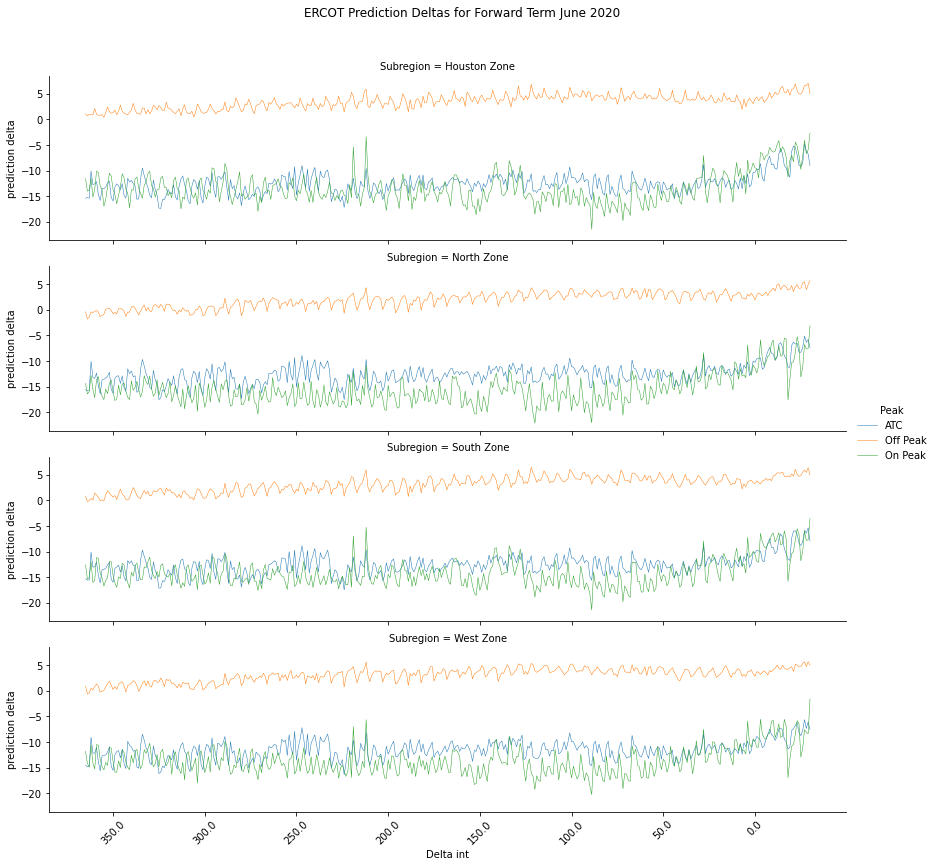

In [59]:
# os.chdir('/Users/jiyoojeong/desktop/C/raw/forwards/spg/ERCOT/')
#if 'figures' not in os.listdir('/Users/jiyoojeong/desktop/C/raw/forwards/spg/ERCOT/'):
#    os.makedirs('/Users/jiyoojeong/desktop/C/raw/forwards/spg/ERCOT/figures')

# plot to see
#ercot_delta_avg = ercot_delta_avg.reset_index()
ercot_delta_avg['Delta int'] = ercot_delta_avg['Delta'].dt.days
#print(ercot_delta_avg)
g = sns.FacetGrid(ercot_delta_avg, col="Subregion", hue='Peak', col_wrap=1, aspect=4)
g.map(plt.plot, 'Delta int', 'prediction delta', linewidth=.5).add_legend()
plt.subplots_adjust(top=.9)
g.fig.suptitle('ERCOT Prediction Deltas for Forward Term June 2020')  # , y=1.05)
# g.fig.title('Ercot Means')
plt.gca().invert_xaxis()


for ax in g.axes.flatten():
    ax.xaxis.set_visible(True)
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45)
    
g.fig.savefig('/Users/jiyoojeong/desktop/C/Nephila/renewables/figures/ercot_means_1y_deltapredict.png')



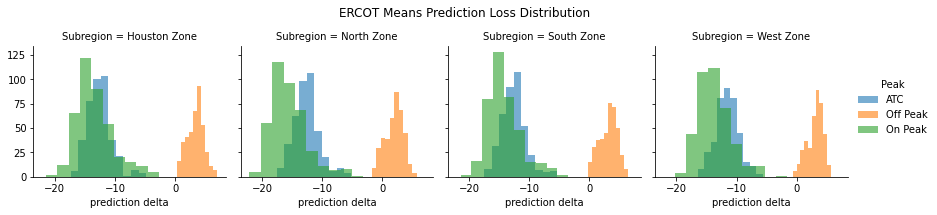

In [67]:
# os.chdir('/Users/jiyoojeong/desktop/C/raw/forwards/spg/ERCOT/')
#if 'figures' not in os.listdir('/Users/jiyoojeong/desktop/C/raw/forwards/spg/ERCOT/'):
#    os.makedirs('/Users/jiyoojeong/desktop/C/raw/forwards/spg/ERCOT/figures')

# plot to see
g = sns.FacetGrid(ercot_delta_avg, col="Subregion", hue='Peak', col_wrap=4)
g.map(plt.hist,'prediction delta', alpha=.6, rwidth=1).add_legend()
plt.subplots_adjust(top=.8)
g.fig.suptitle('ERCOT Means Prediction Loss Distribution')  # , y=1.05)
# g.fig.title('Ercot Means')
#plt.gca().invert_xaxis()
g.fig.savefig('/Users/jiyoojeong/desktop/C/Nephila/renewables/figures/ercot_mean_hist_deltapredict.png')



## PLOT 2 - SD


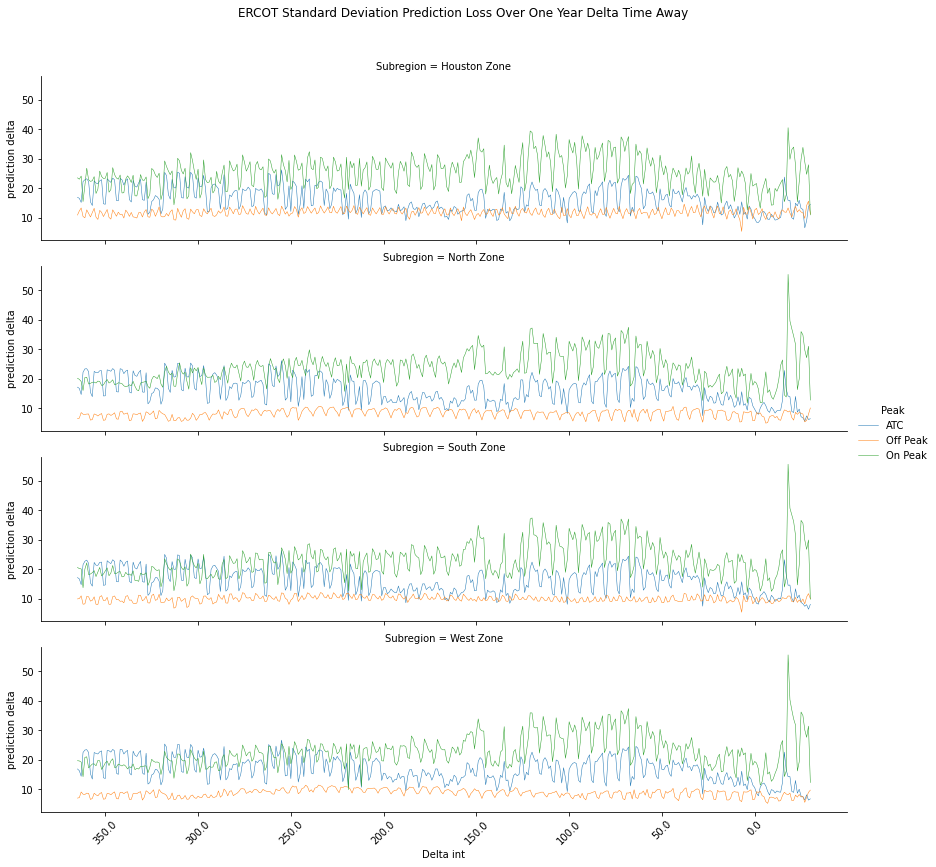

In [72]:
#ercot_delta_sd = ercot_delta_sd.reset_index()
ercot_delta_sd['Delta int'] = ercot_delta_sd['Delta'].dt.days
#print(ercot_delta_avg)
g2 = sns.FacetGrid(ercot_delta_sd, col="Subregion", hue='Peak', col_wrap=1, aspect=4)
g2.map(plt.plot, 'Delta int', 'prediction delta', linewidth=.5).add_legend()
plt.subplots_adjust(top=.9)

g2.fig.suptitle('ERCOT Standard Deviation Prediction Loss Over One Year Delta Time Away')  # , y=1.05)
plt.gca().invert_xaxis() # Invert for time delta plot

for ax in g2.axes.flatten():
    ax.xaxis.set_visible(True)
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45)

#g2.fig.savefig('/Users/jiyoojeong/desktop/C/raw/forwards/spg/ERCOT/figures/ercot_sd_deltapredict.png')
g2.fig.savefig('/Users/jiyoojeong/desktop/C/Nephila/renewables/figures/ercot_sd_1y_deltapredict.png')
g2

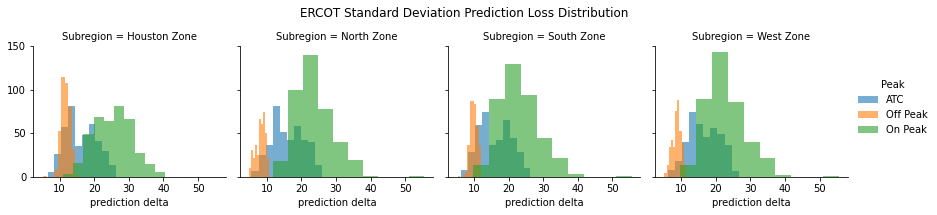

In [73]:
g2 = sns.FacetGrid(ercot_delta_sd, col="Subregion", hue='Peak', col_wrap=4)
#g2.map(plt.plot, 'Delta', 'prediction delta', linewidth=.5).add_legend()
g2.map(plt.hist,'prediction delta', alpha=.6, rwidth=1).add_legend()
plt.subplots_adjust(top=.8)
g2.fig.suptitle('ERCOT Standard Deviation Prediction Loss Distribution')  # , y=1.05)
#plt.gca().invert_xaxis() # Invert for time delta plot

#g2.fig.savefig('/Users/jiyoojeong/desktop/C/raw/forwards/spg/ERCOT/figures/ercot_sd_deltapredict.png')
g2.fig.savefig('/Users/jiyoojeong/desktop/C/Nephila/renewables/figures/ercot_sd_hist_1y_deltapredict.png')
g2

## PLOT 3 MAX

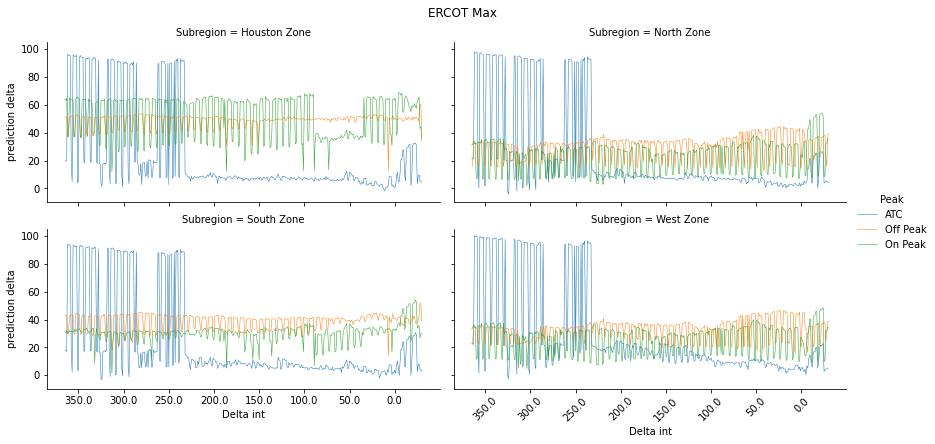

In [74]:
#ercot_delta_max = ercot_delta_max.reset_index()
ercot_delta_max['Delta int'] = ercot_delta_max['Delta'].dt.days
#print(ercot_delta_avg)
g3 = sns.FacetGrid(ercot_delta_max, col="Subregion", hue='Peak', col_wrap=2, aspect=2)
g3.map(plt.plot, 'Delta int', 'prediction delta', linewidth=.5).add_legend()
plt.subplots_adjust(top=.9)

g3.fig.suptitle('ERCOT Max')  # , y=1.05)
plt.gca().invert_xaxis()

for ax in g3.axes.flatten():
    ax.xaxis.set_visible(True)
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45)

g3.fig.savefig('/Users/jiyoojeong/desktop/C/Nephila/renewables/figures/ercot_max_1y_deltapredict.png')

g3

## PLOT 4 MIN

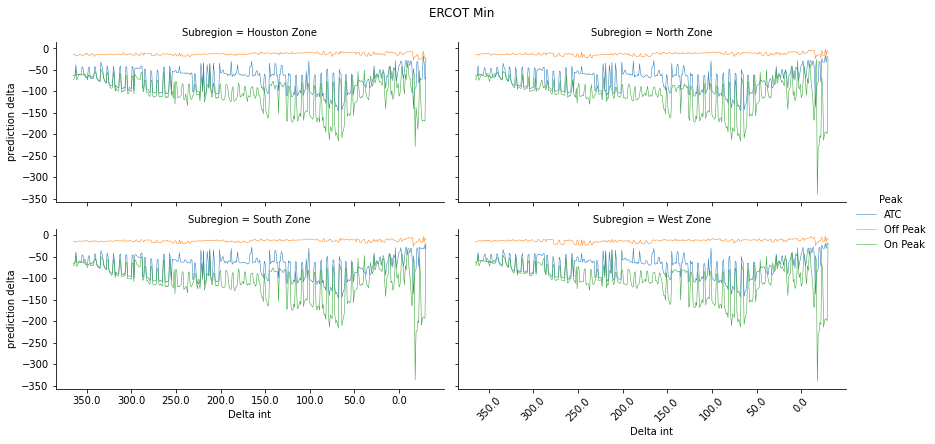

In [76]:
ercot_delta_min = ercot_delta_min.reset_index()
ercot_delta_min['Delta int'] = ercot_delta_min['Delta'].dt.days
#print(ercot_delta_avg)
g4 = sns.FacetGrid(ercot_delta_min, col="Subregion", hue='Peak', col_wrap=2, aspect=2)
g4.map(plt.plot, 'Delta int', 'prediction delta', linewidth=.5).add_legend()
plt.subplots_adjust(top=.9)

g4.fig.suptitle('ERCOT Min')  # , y=1.05)
plt.gca().invert_xaxis()

for ax in g4.axes.flatten():
    ax.xaxis.set_visible(True)
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45)
    
    
g4.fig.savefig('/Users/jiyoojeong/desktop/C/Nephila/renewables/raw/forwards/spg/ERCOT/figures/ercot_min_1y_deltapredict.png')

g4

In [ ]:
#plt.show()

## PLOT 5 - TEST DEALS

In [77]:
# use ercot_rt_h
ercot_rt_h

,date,price,Peak,Subregion,AsOfDate,Term,value,prediction delta
0,2013-06-01,29.885292,ATC,Houston Zone,2013-06-18,2013-06-01,57.108571,-27.223280
1,2013-06-01,29.885292,ATC,Houston Zone,2013-06-19,2013-06-01,48.011429,-18.126137
2,2013-06-01,29.885292,ATC,Houston Zone,2013-06-20,2013-06-01,48.077619,-18.192327
3,2013-06-01,29.885292,ATC,Houston Zone,2013-06-21,2013-06-01,45.779524,-15.894232
4,2013-06-01,29.885292,ATC,Houston Zone,2013-06-24,2013-06-01,46.164762,-16.279470
...,...,...,...,...,...,...,...,...
786834,2020-06-01,16.313958,Off Peak,West Zone,2019-01-07,2020-06-01,15.795300,0.518658
786835,2020-06-01,16.313958,Off Peak,West Zone,2019-01-08,2020-06-01,18.453800,-2.139842
786836,2020-06-01,16.313958,Off Peak,West Zone,2019-01-09,2020-06-01,18.254500,-1.940542
786837,2020-06-01,16.313958,Off Peak,West Zone,2019-01-10,2020-06-01,18.726400,-2.412442


In [81]:
# ONLY LOOK AT 
# ATC, 
# JUNE as of date before June 18, 2014 (one year prior to first as of date), 
# and only June Term Dates

rel_cols = ['AsOfDate', 'Peak', 'Term', 'Subregion', 'value', 'price', 'prediction delta'] 
#value is forward, price is real time

ercot_rt_h_june = ercot_rt_h.loc[(ercot_rt_h['AsOfDate'] <= '2014-06-18')&(ercot_rt_h['Peak'] == 'ATC'), rel_cols]
ercot_rt_h_june['Term Month'] = ercot_rt_h_june['Term'].dt.month
ercot_rt_h_june = ercot_rt_h_june[ercot_rt_h_june['Term Month'] == 6]
ercot_rt_h_june['Term Year'] = ercot_rt_h_june['Term'].dt.year

ercot_rt_h_means = ercot_rt_h_june.groupby(['AsOfDate', 'Subregion', 'Term', 'Term Year']).mean().reset_index()
ercot_rt_h_means

,AsOfDate,Subregion,Term,Term Year,value,price,prediction delta,Term Month
0,2013-06-18,Houston Zone,2013-06-01,2013,57.108571,29.885292,-27.223280,6
1,2013-06-18,Houston Zone,2014-06-01,2014,57.183810,36.724611,-20.459198,6
2,2013-06-18,Houston Zone,2015-06-01,2015,64.101905,31.306792,-32.795113,6
3,2013-06-18,Houston Zone,2016-06-01,2016,60.330000,18.396806,-41.933194,6
4,2013-06-18,Houston Zone,2017-06-01,2017,59.720952,39.440083,-20.280869,6
...,...,...,...,...,...,...,...,...
6239,2014-06-18,West Zone,2016-06-01,2016,51.966667,16.378250,-35.588417,6
6240,2014-06-18,West Zone,2017-06-01,2017,53.863333,24.465028,-29.398306,6
6241,2014-06-18,West Zone,2018-06-01,2018,56.091429,24.348236,-31.743192,6
6242,2014-06-18,West Zone,2019-06-01,2019,58.135238,22.533597,-35.601641,6


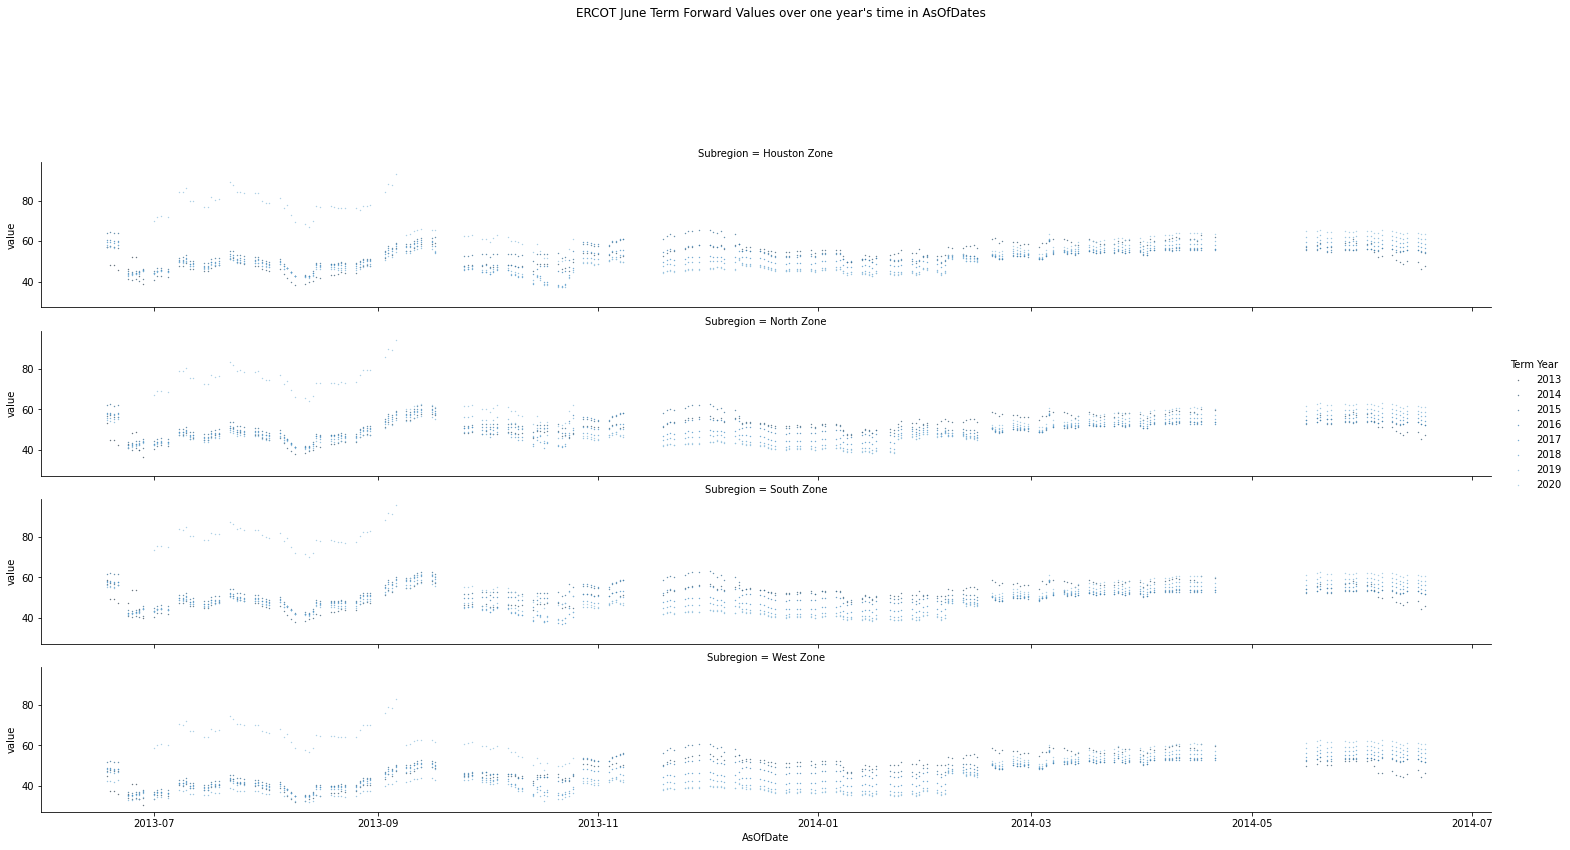

In [120]:
# plot to see
g5 = sns.FacetGrid(ercot_rt_h_means, col="Subregion", hue='Term Year', col_wrap=1, aspect=7, palette='Blues_d')
g5.map(plt.scatter, 'AsOfDate', 'value', marker='.', s=.5).add_legend()
plt.subplots_adjust(top=.8)
#g.figure(figsize=(10, 4))
g5.fig.suptitle('ERCOT June Term Forward Values over one year\'s time in AsOfDates')  # , y=1.05)
# g.fig.title('Ercot Means')
#plt.gca().invert_xaxis()
g.fig.savefig('/Users/jiyoojeong/desktop/C/nephila/renewables/figures/ercot_june_test_means_vals_scatter.png')


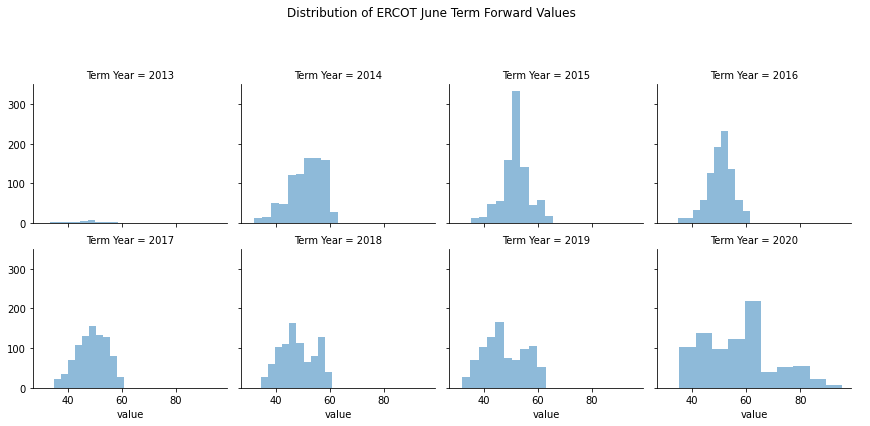

In [86]:
# plot to see
ercot_rt_h_means['AsOfMonth'] = ercot_rt_h_means['AsOfDate'].dt.month
g6 = sns.FacetGrid(ercot_rt_h_means, col="Term Year", col_wrap=4, palette='RdBu')
g6.map(plt.hist, 'value', linewidth=.5, alpha=.5).add_legend()
plt.subplots_adjust(top=.8)
#g.figure(figsize=(10, 4))
g6.fig.suptitle('Distribution of ERCOT June Term Forward Values')  # , y=1.05)
# g.fig.title('Ercot Means')
#plt.gca().invert_xaxis()
g6.fig.savefig('/Users/jiyoojeong/desktop/C/nephila/renewables/figures/ercot_june_test_means_hist_vals.png')


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resultiing Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  exec(code_obj, self.user_global_ns, self.user_ns)


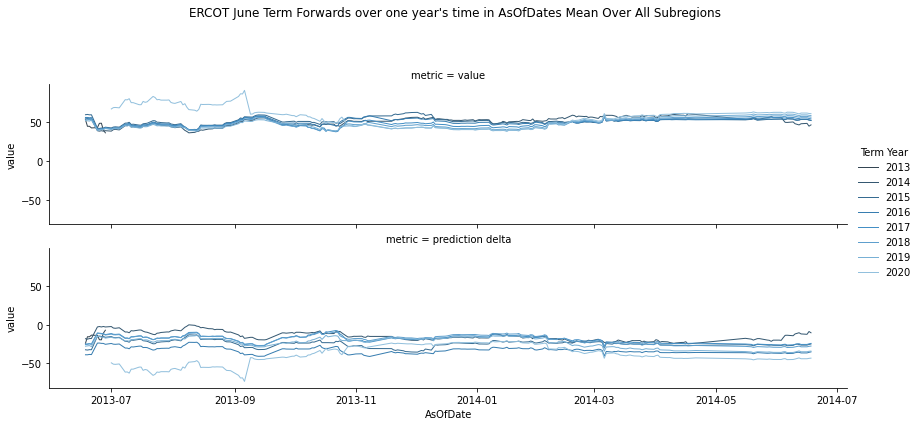

In [105]:
# plot to see
consolidated_rt_h_means = ercot_rt_h_means.groupby(['AsOfDate', 'Term', 'Term Year', 'Term Month']).mean().reset_index()
consolidated_rt_h_m_melt = pd.melt(consolidated_rt_h_means,id_vars=['AsOfDate', 'Term', 'Term Year'],
                           value_vars=['value', 'prediction delta'],
                           var_name='metric')
#print(consolidated_rt_h_m_melt)
g7 = sns.FacetGrid(consolidated_rt_h_m_melt, col="metric", hue='Term Year', col_wrap=1, aspect=4, palette='Blues_d')
g7.map(plt.plot, 'AsOfDate', 'value', linewidth=1).add_legend()
plt.subplots_adjust(top=.8)
#g.figure(figsize=(10, 4))
g7.fig.suptitle('ERCOT June Term Forwards over one year\'s time in AsOfDates Mean Over All Subregions')  # , y=1.05)
# g.fig.title('Ercot Means')
#plt.gca().invert_xaxis()
g7.fig.savefig('/Users/jiyoojeong/desktop/C/nephila/renewables/figures/ercot_test_mean_june_all_markets.png')


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resultiing Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  exec(code_obj, self.user_global_ns, self.user_ns)


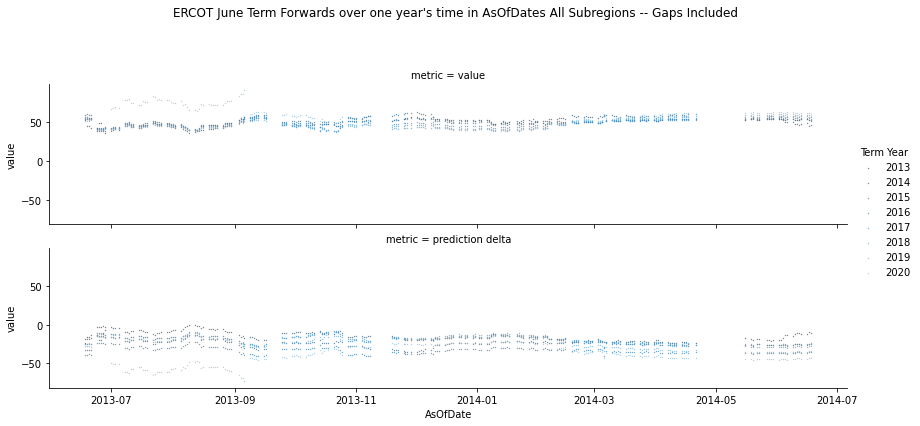

In [118]:
# plot to see
consolidated_rt_h_means = ercot_rt_h_means.groupby(['AsOfDate', 'Term', 'Term Year', 'Term Month']).mean().reset_index()
consolidated_rt_h_m_melt = pd.melt(consolidated_rt_h_means,id_vars=['AsOfDate', 'Term', 'Term Year'],
                           value_vars=['value', 'prediction delta'],
                           var_name='metric')
#print(consolidated_rt_h_m_melt)
g7 = sns.FacetGrid(consolidated_rt_h_m_melt, col="metric", hue='Term Year', col_wrap=1, aspect=4, palette='Blues_d')
g7.map(plt.scatter, 'AsOfDate', 'value', marker='.', s=.4).add_legend()
plt.subplots_adjust(top=.8)
#g.figure(figsize=(10, 4))
g7.fig.suptitle('ERCOT June Term Forwards over one year\'s time in AsOfDates All Subregions -- Gaps Included')  # , y=1.05)
# g.fig.title('Ercot Means')
#plt.gca().invert_xaxis()
g7.fig.savefig('/Users/jiyoojeong/desktop/C/nephila/renewables/figures/ercot_means_test_june_all_markets-GAPS.png')


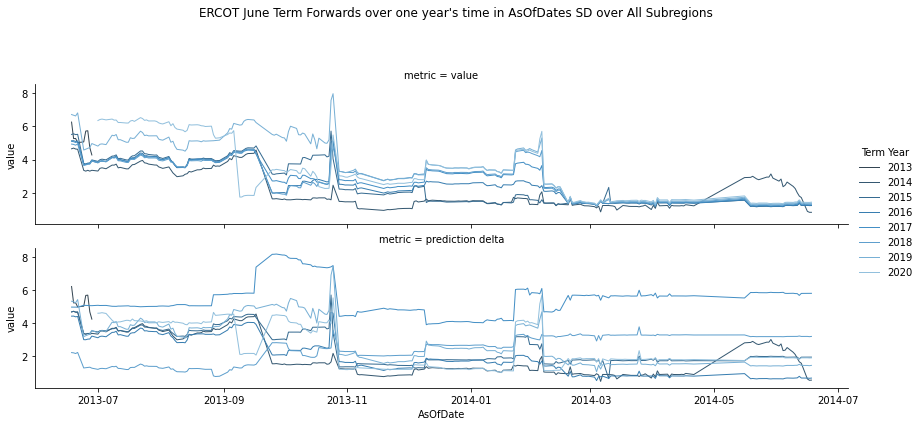

In [109]:
# plot to see
consolidated_rt_h_means = ercot_rt_h_means.groupby(['AsOfDate', 'Term', 'Term Year', 'Term Month']).std().reset_index()
consolidated_rt_h_m_melt = pd.melt(consolidated_rt_h_means,id_vars=['AsOfDate', 'Term', 'Term Year'],
                           value_vars=['value', 'prediction delta'],
                           var_name='metric')
#print(consolidated_rt_h_m_melt)
g7 = sns.FacetGrid(consolidated_rt_h_m_melt, col="metric", hue='Term Year', col_wrap=1, aspect=4, palette='Blues_d')
g7.map(plt.plot, 'AsOfDate', 'value', linewidth=1).add_legend()
plt.subplots_adjust(top=.8)
#g.figure(figsize=(10, 4))
g7.fig.suptitle('ERCOT June Term Forwards over one year\'s time in AsOfDates SD over All Subregions')  # , y=1.05)
# g.fig.title('Ercot Means')
#plt.gca().invert_xaxis()
g7.fig.savefig('/Users/jiyoojeong/desktop/C/nephila/renewables/figures/ercot_test_SD_june_all_markets.png')


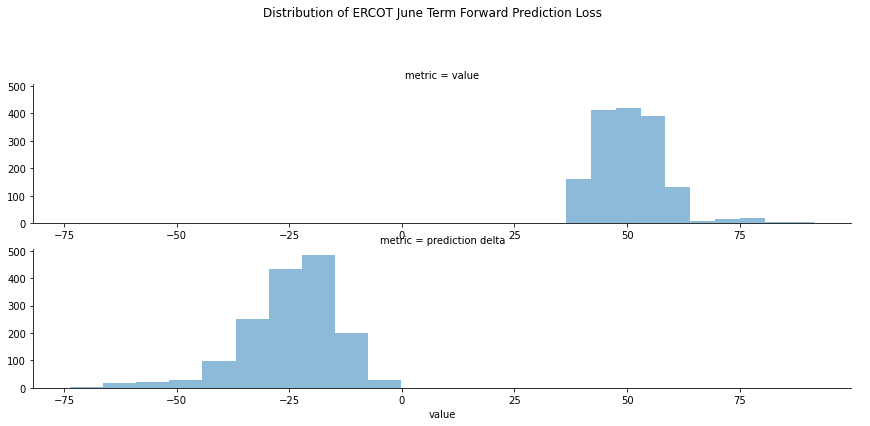

In [99]:
# plot to see
g8 = sns.FacetGrid(consolidated_rt_h_m_melt, col="metric", col_wrap=1, aspect=4, palette='RdBu')
g8.map(plt.hist, 'value', alpha=.5).add_legend()
plt.subplots_adjust(top=.8)
#g.figure(figsize=(10, 4))
g8.fig.suptitle('Distribution of ERCOT June Term Forward Prediction Loss')  # , y=1.05)
# g.fig.title('Ercot Means')
#plt.gca().invert_xaxis()

for ax in g8.axes.flatten():
    ax.tick_params(labelbottom=True)
    
g8.fig.savefig('/Users/jiyoojeong/desktop/C/nephila/renewables/figures/ercot_means_test_hist.png')


Can we take the P90/worst case/best case/expected forward price based off this volatility, and use Prius to price them? Hint: we can use the Prius API “Imposed Intermediate Results” function to impose a forward curve

In [ ]:
# when do we usually price or buy a deal?
# that way I can try to predict the best/worst case from that as of date
